In [64]:
import torch
import torch.nn as nn
import pandas as pd
from numpy import ceil

#import softmax
from scipy.special import softmax

phrase_embeddings = torch.load('../phrase_embeddings.pt')
phrase_embeddings.shape

torch.Size([85, 768])

In [73]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size,layers=1):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x, mask):
        
        h0 = torch.zeros(layers, x.size(0), hidden_size).to(x.device)  # Initial hidden state
        
        # pack the padded sequence
        x = nn.utils.rnn.pack_padded_sequence(x, mask, batch_first=True, enforce_sorted=False)
        
        # pass it through the RNN
        out, _ = self.rnn(x, h0)
        
        # unpack the sequence
        out, _ = nn.utils.rnn.pad_packed_sequence(out, batch_first=True)
        
        # get the output from the last time step
        out = self.fc(out[:, -1, :])  # Take the output from the last time step
        return out


In [74]:

def city_to_dataset_path(city):
    return f'../Part C preprocessed data/city{city}_sequences' + ('.parquet' if city == 'A' else '.txt')

def city_to_mapping_path(city):
    return f'../Part C preprocessed data/city{city}_mapping.csv'

def txt_to_sequences(txt_file_path):
    sequences = []
    with open(txt_file_path, 'r') as file:
        lines = file.readlines()
        for line in lines:
            # Extract the sequence
            sequence = line.split('[')[1].split(']')[0]
            sequence = sequence.split('),')
            sequence = [tuple(map(lambda y: ceil(int(y)/20), x.replace('(', '').replace(')', '').split(','))) for x in sequence]
            sequences.append(sequence)

    return sequences


def parquet_to_sequences(parquet_file_path):
    sequences = pd.read_parquet(parquet_file_path)

    seq = []
    for str in sequences['sequence_str']:
        # First split the string by ;
        str_split = str.split(';')
        # Then split each pair by ,
        seq.append([tuple(map(lambda y: int(ceil(int(y)/10000)), x.split(','))) for x in str_split])
    return seq

def city_to_sequences(city):
    if city == 'A':
        return parquet_to_sequences(city_to_dataset_path(city))
    else:
        return txt_to_sequences(city_to_dataset_path(city))

def coordinates_to_vector_map(path_to_mapping_csv):
    
    # Load the mapping
    df = pd.read_csv(path_to_mapping_csv)

    # Load the sequences
    df["POI_Probabilities"] = df.iloc[:,2:(2+85)].apply(lambda x: torch.tensor(x.values), axis=1)
    df['Input_features'] = df.iloc[:,(2+85):(2+85+768)].apply(lambda x: torch.tensor(x.values), axis=1)
    
    # Drop the columns that are not needed
    df = df.drop(df.columns[2:(2+85+768)], axis=1)
    
    return df


        


In [75]:
def sequence_to_vectors(tup_sequence, coordinates_to_vector_map_df):
    if len(tup_sequence) < 2:
        print(tup_sequence)
        raise ValueError('The sequence must contain at least 2 coordinates')
        
    df = coordinates_to_vector_map_df
    input_vector_sequence = []
    target_labels = None
    
    for i, tup in enumerate(tup_sequence):
        x, y = tup
        
        series = df.loc[(df['x'] == x) & (df['y'] == y)]
        
        # If the series is empty, the target is a softmax of 85 zeros
        if series.empty:
            
            target_labels = torch.tensor([0]*85)  # Shape: [85]

            # Ensure target_labels is of shape [768]
            target_labels = torch.nn.functional.softmax(target_labels.float(), dim=0)  # Apply softmax
            target_labels = target_labels.unsqueeze(0)  # Shape: [1, 85]

            # Perform matrix multiplication
            result = torch.matmul(phrase_embeddings.T, target_labels.T)  # Shape: [768, 1]

            input_vector_sequence.append(result.squeeze())
            continue
        
        if i == len(tup_sequence) - 1:
            target_labels = series['POI_Probabilities'].values[0]
        else:
            input_vector_sequence.append(series['Input_features'].values[0])
    
    if not input_vector_sequence:
        print(tup_sequence)
        raise ValueError('The input vector sequence cannot be empty')
    
    return torch.stack(input_vector_sequence), target_labels.squeeze()

In [76]:
coordinates_to_vector_map_df = coordinates_to_vector_map('../Part C preprocessed data/cityA_mapping.csv')
coordinates_to_vector_map_df.head(30)

for sequence in city_to_sequences('B'):
    input_vector_sequence, target_labels = sequence_to_vectors(sequence, coordinates_to_vector_map_df)
    print(input_vector_sequence.shape, target_labels.shape)
    

torch.Size([2, 768]) torch.Size([85])
torch.Size([2, 768]) torch.Size([85])
torch.Size([2, 768]) torch.Size([85])
torch.Size([2, 768]) torch.Size([85])
torch.Size([2, 768]) torch.Size([85])
torch.Size([2, 768]) torch.Size([85])
torch.Size([2, 768]) torch.Size([85])
torch.Size([2, 768]) torch.Size([85])
torch.Size([2, 768]) torch.Size([85])
torch.Size([2, 768]) torch.Size([85])
torch.Size([2, 768]) torch.Size([85])
torch.Size([2, 768]) torch.Size([85])
torch.Size([2, 768]) torch.Size([85])
torch.Size([2, 768]) torch.Size([85])
torch.Size([2, 768]) torch.Size([85])
torch.Size([2, 768]) torch.Size([85])
torch.Size([2, 768]) torch.Size([85])
torch.Size([2, 768]) torch.Size([85])
torch.Size([3, 768]) torch.Size([85])
torch.Size([2, 768]) torch.Size([85])
torch.Size([2, 768]) torch.Size([85])
torch.Size([2, 768]) torch.Size([85])
torch.Size([2, 768]) torch.Size([85])
torch.Size([2, 768]) torch.Size([85])
torch.Size([2, 768]) torch.Size([85])
torch.Size([2, 768]) torch.Size([85])
torch.Size([

In [77]:
from torch.utils.data import Dataset, DataLoader

class SequenceDataset(Dataset):
    def __init__(self, city_names):
        self.sequences = []
        # if city name is not a list make it a list
        if not isinstance(city_names, list):
            city_names = [city_names]
        
        self.city_mapping_indices = []
        
        for city in city_names:
            seqs = city_to_sequences(city)
            mapping = coordinates_to_vector_map(city_to_mapping_path(city))
            for seq in seqs:
                if len(seq) < 2:
                    continue
                self.sequences.append(seq)
                self.city_mapping_indices.append(mapping)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        input_vector_sequence, target_labels = sequence_to_vectors(self.sequences[idx], self.city_mapping_indices[idx])
        return input_vector_sequence, target_labels
    
def collate_fn(batch):
    # Extract sequences and targets
    sequences, targets = zip(*batch)
    
    # Pad the sequences
    sequences = nn.utils.rnn.pad_sequence(sequences, batch_first=True)
    
    # Stack the targets
    targets = torch.stack(targets)
    
    # Create a mask
    mask = torch.tensor([len(x) for x in sequences], dtype=torch.long)
    return sequences, targets, mask

In [78]:
train_loader = DataLoader(SequenceDataset(['A', 'B']), batch_size=32, shuffle=True, collate_fn=collate_fn)
train_loader.dataset.__getitem__(7)[0].shape

torch.Size([2, 768])

In [79]:
input_size = 768
hidden_size = 128  # You can adjust the hidden size as needed
output_size = 85
layers = 2

model = SimpleRNN(input_size, hidden_size, output_size, layers)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Epoch [1/50], Loss: 3.3162686824798584
Epoch [2/50], Loss: 3.1894257068634033
Epoch [3/50], Loss: 2.88175892829895
Epoch [4/50], Loss: 3.0562186241149902
Epoch [5/50], Loss: 3.5948173999786377
Epoch [6/50], Loss: 3.2098371982574463
Epoch [7/50], Loss: 3.213092565536499
Epoch [8/50], Loss: 2.6695187091827393
Epoch [9/50], Loss: 2.479311227798462
Epoch [10/50], Loss: 3.6123290061950684
Epoch [11/50], Loss: 2.27156400680542
Epoch [12/50], Loss: 1.3424469232559204
Epoch [13/50], Loss: 2.1772382259368896
Epoch [14/50], Loss: 2.2977712154388428
Epoch [15/50], Loss: 2.517943859100342
Epoch [16/50], Loss: 2.5355186462402344
Epoch [17/50], Loss: 2.1220197677612305
Epoch [18/50], Loss: 1.3830629587173462
Epoch [19/50], Loss: 2.6175618171691895
Epoch [20/50], Loss: 2.228093147277832
Epoch [21/50], Loss: 0.8515920042991638
Epoch [22/50], Loss: 1.0305275917053223
Epoch [23/50], Loss: 1.7169467210769653
Epoch [24/50], Loss: 2.0217387676239014
Epoch [25/50], Loss: 2.931192636489868
Epoch [26/50], Los

Text(0, 0.5, 'Loss')

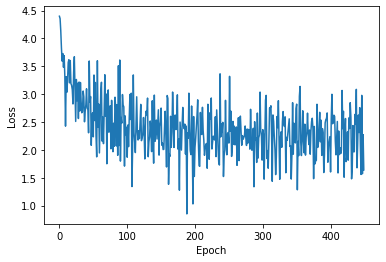

In [80]:

# Training loop
num_epochs = 50

losses = []

for epoch in range(num_epochs):
    
    for i, (sequences, targets, mask) in enumerate(train_loader):
        # Ensure sequences and mask are tensors with the same dtype
        sequences = sequences.to(torch.float32)
        mask = mask.to(torch.long)
        targets = targets.to(torch.float32)
        
        # Forward pass
        outputs = model(sequences, mask)
        loss = criterion(outputs, targets)
        
        losses.append(loss.item())
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')
            
# Save the model
# torch.save(model.state_dict(), 'rnn_model.pth')?

# plot the losses
import matplotlib.pyplot as plt

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')